In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader 
from torch.autograd import Variable
from tqdm import trange

torch.manual_seed(0)

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
    
#https://www.kaggle.com/code/anthokalel/statistical-tests-lstm-pytorch/notebook

In [3]:
X = pd.read_csv("../data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
y = pd.read_csv("../data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("../data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded GW-SW Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
GW=X.iloc[:,:23]
SW=X.iloc[:,23:]
met=pd.read_csv("../data/processed/DailyMet.CSV",
                parse_dates=['Datetime'],
                index_col=['Datetime'])

X=pd.concat([X, met], axis=1)
MET=X.iloc[:,-4:]
#print(X)
train_names=X.columns


#Add Y columns as a separate column
y['timestamp']=y.index
y['timestamp']=pd.to_datetime(y['timestamp']).dt.tz_convert(None)
#=pd.to_datetime(['timestamp'], format='%Y-%m-%d %H:%M:%S')
y=y.rename(columns={'Gage_Height':'Wakulla', 'timestamp':'Datetime'})
y=y.set_index('Datetime')

df=X.merge(y, how='inner', right_index=True, left_index=True)
del(X,y)


df

Initial Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St  Marks River @ San Marcos de Apalachee S P 
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded GW-SW Input Shape:  (1101, 64)


,USGS-LESTER LEWIS/S788,NWFWMD-BIKE TRAIL / NITRATE POT MAP/S795,NWFWMD-BRADFORD BROOK DEEP/S793,NWFWMD-BRADFORD BROOK SHALLOW,TOM BROWN TEST/S791,USGS-OLSON RD/S677,NWFWMD-HQ FLORIDAN OBS/S704,USGS-LAKE JACKSON INTERMEDIATE/S706,NWFWMD-NITRATE 5/S796,FGS - SULLIVAN SINK 1,...,Lake Miccosukee @ US90 Outfall,LAKE IAMONIA EAST,LAKE KILLARNY AT MCLAUGHLIN DRIVE,LAKE KANTURK AT CLIFDEN DR,ST MARKS RIVER - UPPER DISCHARGE BEFORE SWALLET,Precip,Max_Temp,Min_Temp,Mean_Temp,Wakulla
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-27,6.340833,15.025417,20.722396,38.613021,25.915625,33.623333,55.489583,83.025701,21.439062,7.711354,...,79.397917,98.302344,73.279792,73.315469,9.488892,0.00000,58,39,48.5,5.470909
2017-01-28,6.220729,15.082292,20.793333,38.617604,26.018438,33.803750,55.505833,83.025701,21.371042,7.638542,...,79.373958,98.265703,73.217240,73.252917,9.488892,0.00000,51,38,44.5,5.418021
2017-01-29,6.153437,15.110938,20.879062,38.627187,26.037917,33.853750,55.585000,83.025701,21.317083,7.526875,...,79.366510,98.233958,73.161146,73.196979,9.488892,0.00000,63,38,50.5,5.345313
2017-01-30,6.046042,15.071146,20.889583,38.558646,25.949375,33.879167,55.582917,83.025701,21.238854,7.345208,...,79.346510,98.205833,73.118229,73.152708,9.488892,0.00000,65,31,48.0,5.237917
2017-01-31,5.991562,15.027812,20.922917,38.519583,25.973021,33.963750,55.602500,83.025701,21.177500,7.172917,...,79.329167,98.185781,73.079583,73.115833,9.488892,0.00000,75,35,55.0,5.171563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-28,5.997887,10.917344,16.378229,33.653193,21.118021,27.338963,54.374673,82.538396,18.483385,5.557500,...,76.656413,96.246719,70.831029,67.873646,9.473802,0.00000,67,36,51.5,4.814896
2020-01-29,6.007684,10.918021,16.392500,33.617434,21.132604,27.251736,54.369017,82.511750,18.478021,5.566021,...,76.654269,96.208203,70.778004,67.787083,9.482474,0.06000,53,35,44.0,4.811146
2020-01-30,5.852846,10.912812,16.374063,33.564070,21.096042,27.149925,54.339330,82.490667,18.457708,5.573781,...,76.650928,96.175104,70.724979,67.700573,9.492500,0.00000,65,48,56.5,4.807292


In [4]:
def scale_and_split(df):
    train, val = train_test_split(df, test_size=0.3, shuffle = False)
    val, test = train_test_split(val, test_size=0.7, shuffle = False)
    
    #Use train set as the sclaer to prevent data leakage
    X_scaler = StandardScaler().fit(train.iloc[:,:-1])
    train_Xscaled = X_scaler.transform(train.iloc[:,:-1])
    y_scaler= MinMaxScaler().fit(train.iloc[:,-1:])
    train_yscaled= y_scaler.transform(train.iloc[:,-1:])
    
    train_scaled = pd.DataFrame(np.append(train_Xscaled, train_yscaled,1), columns = df.columns[:])
 
    
    val_Xscaled = X_scaler.transform(val.iloc[:,:-1])
    val_yscaled= y_scaler.transform(val.iloc[:,-1:])
    val_scaled = pd.DataFrame(np.append(val_Xscaled, val_yscaled,1), columns = df.columns[:])
    
    test_Xscaled = X_scaler.transform(test.iloc[:,:-1])
    test_yscaled= y_scaler.transform(test.iloc[:,-1:])
    test_scaled = pd.DataFrame(np.append(test_Xscaled, test_yscaled,1), columns = df.columns[:])
    
    full_scaled_X=X_scaler.transform(df.iloc[:,:-1])
    full_scaled_y=y_scaler.transform(df.iloc[:,-1:])
    
    return train_scaled, val_scaled, test_scaled, X_scaler, y_scaler, full_scaled_X, full_scaled_y

#Old one

def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   
    X_train, y_train = train[:len(train)-seq_len][inputs], train[[output]]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(val)-seq_len][inputs], test[[output]]
    #test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test

'''
## Try New One
def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   
    X_train, y_train = train[inputs], train[output][seq_len-1:]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test
'''
###Theory here is that we take [seq_len] numbered away from trainX and pass it to Val_X 
#and same with val to Test set
#May not be necessary

'\n## Try New One\ndef prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   \n    X_train, y_train = train[inputs], train[output][seq_len-1:]\n    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]\n    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]\n    return X_train, y_train, X_val, y_val, X_test, y_test\n'

In [5]:
parameters = {'inputs':train_names,
              'input_size': len(train_names),
              'outputs':['Wakulla'],
              'seq_len': 30,
              'hidden_size': 64, #Same as batch
              'batch_size_train':64,
              'batch_size_val':8,
              'batch_size_test':8,
              'lr':0.0005,
              'epochs':10,
              'num_layers':1   #Number of LSTM layers
             }

train, val, test, X_scaler, y_scaler, full_scaled_X, full_scaled_y = scale_and_split(df) 
#inputs=parameters['inputs']
#output=parameters['outputs'][0]
#seq_len=parameters['seq_len']
#rint(train[output][seq_len-1:])




X_train, y_train, X_val, y_val, X_test, y_test = prepare_inputs_outputs(train, val, test, 
                                                                        parameters['seq_len'], 
                                                                        parameters['inputs'], 
                                                                        parameters['outputs'][0])
print(len(y_train)+len(y_val)+len(y_test))                                                           

1101


In [6]:
a=[0,1,2,3,4,5,6,7,8]
a[:3-1]

[0, 1]

In [7]:
class TimeSeries(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(np.array(X) ,dtype=torch.float32)
        self.y = torch.tensor(np.array(y) ,dtype=torch.float32)
        #self.column_input = column_input
        #self.column_output = column_output
        self.seq_len = seq_len
        
    #Gets the input sequence [X : X +seq_len], adn the corresponding, singular y+seq_len    
    def __getitem__(self,idx):
        return self.X[idx:idx+self.seq_len-1], self.y[idx+self.seq_len-1]

    def __len__(self):
        return len(self.X) - (self.seq_len-1)
    
    
def get_dataloader(X, y,seq_len, batch_size):
    return DataLoader(TimeSeries(X, y, seq_len),  batch_size, shuffle=False, drop_last = True)

In [60]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.3)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(hn)#first Dense
        out = self.relu(out)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out

In [61]:
New_LSTM=LSTM_Model(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
New_LSTM

LSTM_Model(
  (lstm): LSTM(68, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [62]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs):


    train_val_history = {'train': [],
                        'val': []}
    for i in trange(epochs):
        for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            #print(inputs.shape)
            y_pred = model(inputs)
            #print(y_pred.shape)
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
           
            single_loss = torch.sqrt(loss_function(y_pred, labels_3D)) #RMSE

            single_loss.backward()

            optimizer.step()

        train_val_history['train'].append(single_loss.item())
        #print("Training data : " + f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        for j, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = model(inputs)

            single_loss = torch.sqrt(loss_function(y_pred, labels_3D))

        train_val_history['val'].append(single_loss.item())
        if i % 20 == 0:
            print("Training data : epoch: ", i, " loss: ", train_val_history['train'][-1])
            print("Validation data :  epoch: ", i, " loss: ", train_val_history['val'][-1])

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, train_val_history

In [63]:
train_loader = get_dataloader(X_train, y_train, parameters['seq_len'],parameters['batch_size_train'])
val_loader = get_dataloader(X_val, y_val, parameters['seq_len'],parameters['batch_size_val'])
test_loader = get_dataloader(X_test, y_test, parameters['seq_len'], parameters['batch_size_test'])
full_loader=get_dataloader(full_scaled_X, full_scaled_y, parameters['seq_len'], parameters['batch_size_test'])
#model = New_LSTM(input_size=len(parameters['inputs']), hidden_layer_size=64, output_size=1, seq_len=parameters['seq_len']).to(device)
optimizer = torch.optim.Adam(New_LSTM.parameters(), lr=parameters['lr'])
loss_function = nn.MSELoss()


model_LSTM, train_val_history = train_model(New_LSTM, 
                                                train_loader, 
                                                val_loader,
                                                loss_function, 
                                                optimizer, 
                                                parameters['epochs'])
                                                

 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.59it/s]

Training data : epoch:  0  loss:  0.4097948670387268
Validation data :  epoch:  0  loss:  0.028970619663596153


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


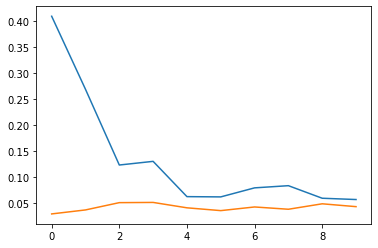

In [64]:
plt.plot(train_val_history['train'])
plt.plot(train_val_history['val'])

0.02782540463166917

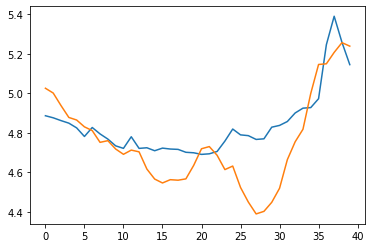

In [65]:
test_list=[] 
labels_list=[]
for j, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)
            test_list.append(y_pred.squeeze().tolist())
            labels_list.append(labels.squeeze().tolist())
            single_loss = torch.sqrt(loss_function(y_pred, labels_3D))
predic_list = [item for sublist in test_list for item in sublist]
predictions=np.array(predic_list).reshape(-1,1)

real_y_list=[item for sublist in labels_list for item in sublist]
real_y=np.array(real_y_list).reshape(-1,1)

predictions=y_scaler.inverse_transform(predictions)
real_y=y_scaler.inverse_transform(real_y)
#print(predictions.shape)
plt.plot(predictions)
plt.plot(real_y)

from sklearn.metrics import mean_squared_error as mse

mse(predictions, real_y)

In [66]:
from sklearn.metrics import mean_squared_error as mse

full_label=[]
full_pred=[]

train_label=[]
train_pred=[]
val_label=[]
val_pred=[]
test_label=[]
test_pred=[]

for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)          
            train_pred.append(y_pred.squeeze().tolist())
            train_label.append(labels.squeeze().tolist())
train_predictions_l = [item for sublist in train_pred for item in sublist]
train_predictions=np.array(train_predictions_l).reshape(-1,1)

train_real_y_l=[item for sublist in train_label for item in sublist]
train_real_y=np.array(train_real_y_l).reshape(-1,1)

train_predictions=y_scaler.inverse_transform(train_predictions)
train_real_y=y_scaler.inverse_transform(train_real_y)
print("train  MSE: ", mse(train_predictions, train_real_y))


for j, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)            
            val_pred.append(y_pred.squeeze().tolist())
            val_label.append(labels.squeeze().tolist())


val_predictions_l = [item for sublist in val_pred for item in sublist]
val_predictions=np.array(val_predictions_l).reshape(-1,1)

val_real_y_l=[item for sublist in val_label for item in sublist]
val_real_y=np.array(val_real_y_l).reshape(-1,1)

val_predictions=y_scaler.inverse_transform(val_predictions)
val_real_y=y_scaler.inverse_transform(val_real_y)
print("val  MSE: ", mse(val_predictions, val_real_y))

for j, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)        
            test_pred.append(y_pred.squeeze().tolist())
            test_label.append(labels.squeeze().tolist())

test_predictions_l = [item for sublist in test_pred for item in sublist]
test_predictions=np.array(test_predictions_l).reshape(-1,1)

test_real_y_l=[item for sublist in test_label for item in sublist]
test_real_y=np.array(test_real_y_l).reshape(-1,1)

test_predictions=y_scaler.inverse_transform(test_predictions)
test_real_y=y_scaler.inverse_transform(test_real_y)
print("test  MSE: ", mse(test_predictions, test_real_y))

train  MSE:  0.023863846575405048
val  MSE:  0.07307398801094275
test  MSE:  0.02782540463166917


Full MSE:  0.033841770001152904


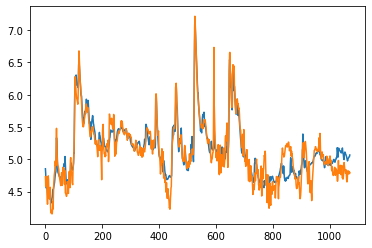

In [67]:
full_pred=[]
full_label=[]
for j, data in enumerate(full_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)
            full_pred.append(y_pred.squeeze().tolist())
            full_label.append(labels.squeeze().tolist())

full_predictions_l = [item for sublist in full_pred for item in sublist]
full_predictions=np.array(full_predictions_l).reshape(-1,1)

full_real_y_l=[item for sublist in full_label for item in sublist]
full_real_y=np.array(full_real_y_l).reshape(-1,1)

full_predictions=y_scaler.inverse_transform(full_predictions)
full_real_y=y_scaler.inverse_transform(full_real_y)

print("Full MSE: ", mse(full_predictions, full_real_y))

plt.plot(full_predictions)
plt.plot(full_real_y)


In [68]:
train  MSE:  0.03400184075674894
val  MSE:  0.10336342906543683
test  MSE:  0.04382218300791058

SyntaxError: invalid syntax (<ipython-input-68-8888cefd2a13>, line 1)